In [4]:
# importing the required libraries
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [5]:
# importing the training data from the training file already present in EMNIST dataset
training = torch.utils.data.DataLoader(torchvision.datasets.EMNIST(root = '/results/', split = 'letters' , train = True, download = True, transform = torchvision.transforms.Compose([                 lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,),(0.3081,))])),batch_size = 50, shuffle = True)
# importing the testing data
testing = torch.utils.data.DataLoader(torchvision.datasets.EMNIST(root = '/results/', split = 'letters' , train = False, download = True, transform = torchvision.transforms.Compose([                 lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,),(0.3081,))])),batch_size = 1000, shuffle = True)



In [6]:
# creating variables to check the testing data
examples = enumerate(testing)
batch_idx, (example_data, example_targets) = next(examples)

In [7]:
example_data.shape

torch.Size([1000, 1, 28, 28])

In [8]:
example_targets.shape

torch.Size([1000])

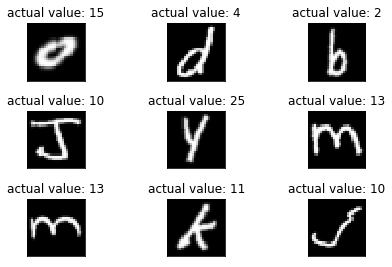

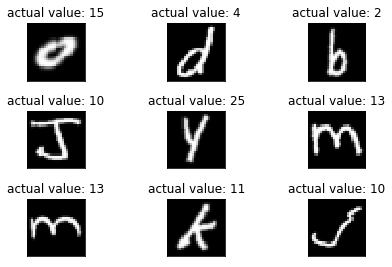

In [9]:
# creating a visual representation of the data which will be using, for better understanding
fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap = 'gray', interpolation = None)
    plt.title("actual value: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig
    
    

In [10]:
# creating the neural network class. this class will consist of 1 convolutional layer, 1 max pooling layer and 3 linear layers for now. these layers will be connected by the widely used ReLU activation function. we will be using the Log softmax function for the output layer. these parameters will be varied during the subsequent runs to improve the accuracy
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
#         input is 1X28X28, output is 26 letters
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(20, 30, kernel_size = 3, stride = 1, padding = 1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        self.fc1 = nn.Linear(30 * 3 * 3, 150)
        self.fc2 = nn.Linear(150, 27)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x),0.01)
        x = self.pool1(x)
        x = F.leaky_relu(self.conv2(x),0.01)
        x = self.pool2(x)
        x = F.leaky_relu(self.conv3(x),0.01)
        x = self.pool3(x)
        x = x.view(-1, 30 * 3 *3)
        x = F.leaky_relu(self.fc1(x),0.01)
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

In [11]:
# defining the relationship between input and output sizes for usage afterwards
def outputsize(in_size,kernel_size,stride,padding):
    output = int((in_size-kernel_size+2*(padding)) / stride) + 1
    return output
# defining the various hyperparameters
epochs = 3 
log_interval = 200
network = Net()
optimizer = optim.SGD(network.parameters(), lr = 0.1, momentum = 0.21)
# creating counters for our results i.e for training losses, test losses, no. of sample trained and no.of samples tested
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(training.dataset) for i in range(epochs+1)]

In [12]:
# defining the training network
def train(epoch):
    network.train()
    for batch_idx, (data,target) in enumerate(training):
#       making all the gradients zero before the start of each epoch
        optimizer.zero_grad()
#     input output and backpropagation steps along with the application of NLL loss function for now
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
#         printing the results after each mini batch has been trained during a particular epoch
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx*len(data), len(training.dataset), 100. *batch_idx / len(training), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*100) + ((epoch-1)*len(training.dataset)))
            torch.save(network.state_dict(), '/results/model.pth')
            torch.save(optimizer.state_dict(), '/results/optimizer.pth')
    

In [13]:
# defining the testing network
def test():
    network.eval()
    test_loss = 0
    correct = 0
    losstest = []
#   calculating the loss for each sample and the accuracy
    with torch.no_grad():
        for data, target in testing:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average = False).item()
            pred = output.data.max(1, keepdim = True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
#         initialising the various parameters to calculate accuracy and print it
        test_loss /= len(testing.dataset)
        losstest.append(test_loss)
        print('\nTest set: Avg. Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(testing.dataset), 100. *correct / len(testing.dataset)))
        
    

In [14]:
# initializing the entire network with the datasets and using the above functions to calculate the accuracy
# first checking the accuracy with random guesses(network uninitialised)
test()
for epoch in range(3):
    train(epoch)
    test()


C:\Users\admin\anaconda3\lib\site-packages\torch\nn\_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. Loss: 3.2942, Accuracy: 1103/20800 (5%)

Train Epoch: 0 [0/124800 (0%)]	Loss: 3.296620
Train Epoch: 0 [10000/124800 (8%)]	Loss: 0.744627
Train Epoch: 0 [20000/124800 (16%)]	Loss: 0.504993
Train Epoch: 0 [30000/124800 (24%)]	Loss: 0.191566
Train Epoch: 0 [40000/124800 (32%)]	Loss: 0.363268
Train Epoch: 0 [50000/124800 (40%)]	Loss: 0.416004
Train Epoch: 0 [60000/124800 (48%)]	Loss: 0.202211
Train Epoch: 0 [70000/124800 (56%)]	Loss: 0.235978
Train Epoch: 0 [80000/124800 (64%)]	Loss: 0.286620
Train Epoch: 0 [90000/124800 (72%)]	Loss: 0.185843
Train Epoch: 0 [100000/124800 (80%)]	Loss: 0.341285
Train Epoch: 0 [110000/124800 (88%)]	Loss: 0.360478
Train Epoch: 0 [120000/124800 (96%)]	Loss: 0.403693

Test set: Avg. Loss: 0.3016, Accuracy: 18640/20800 (89%)

Train Epoch: 1 [0/124800 (0%)]	Loss: 0.255163
Train Epoch: 1 [10000/124800 (8%)]	Loss: 0.352388
Train Epoch: 1 [20000/124800 (16%)]	Loss: 0.260893
Train Epoch: 1 [30000/124800 (24%)]	Loss: 0.353074
Train Epoch: 1 [40000/1248

In [169]:
import matplotlib.image as mpimg

img=mpimg.imread('image 4.jpeg')

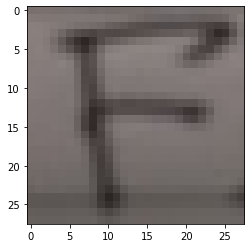

In [139]:
plt.imshow(img)

In [140]:
img

array([[[121, 111, 109],
        [122, 112, 110],
        [122, 112, 110],
        ...,
        [122, 114, 112],
        [124, 116, 113],
        [124, 116, 113]],

       [[130, 120, 118],
        [129, 119, 117],
        [128, 118, 116],
        ...,
        [109, 101,  99],
        [122, 114, 112],
        [132, 124, 121]],

       [[137, 127, 125],
        [136, 126, 124],
        [134, 124, 122],
        ...,
        [ 73,  65,  63],
        [100,  92,  90],
        [125, 117, 115]],

       ...,

       [[ 92,  87,  83],
        [ 92,  87,  83],
        [ 91,  86,  83],
        ...,
        [ 94,  89,  86],
        [ 88,  83,  80],
        [ 82,  77,  74]],

       [[ 99,  94,  90],
        [ 98,  93,  89],
        [ 98,  93,  90],
        ...,
        [104,  99,  96],
        [102,  97,  94],
        [100,  95,  92]],

       [[102,  97,  93],
        [101,  96,  92],
        [101,  96,  93],
        ...,
        [106, 101,  98],
        [106, 101,  98],
        [106, 101,  98]]

In [141]:
img.shape

(28, 28, 3)

In [154]:
trans = torchvision.transforms.Compose([ torchvision.transforms.Grayscale(num_output_channels = 1), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,),(0.3081,))])

In [144]:
b

tensor([[[1.1159, 1.1286, 1.1286,  ..., 1.1286, 1.1541, 1.1541],
         [1.2305, 1.2177, 1.2050,  ..., 0.9632, 1.1286, 1.2559],
         [1.3196, 1.3068, 1.2814,  ..., 0.5049, 0.8486, 1.1668],
         ...,
         [0.7468, 0.7468, 0.7341,  ..., 0.7722, 0.6959, 0.6195],
         [0.8359, 0.8232, 0.8232,  ..., 0.8995, 0.8741, 0.8486],
         [0.8741, 0.8613, 0.8613,  ..., 0.9250, 0.9250, 0.9250]],

        [[0.9886, 1.0013, 1.0013,  ..., 1.0268, 1.0523, 1.0523],
         [1.1032, 1.0904, 1.0777,  ..., 0.8613, 1.0268, 1.1541],
         [1.1923, 1.1795, 1.1541,  ..., 0.4031, 0.7468, 1.0650],
         ...,
         [0.6831, 0.6831, 0.6704,  ..., 0.7086, 0.6322, 0.5559],
         [0.7722, 0.7595, 0.7595,  ..., 0.8359, 0.8104, 0.7850],
         [0.8104, 0.7977, 0.7977,  ..., 0.8613, 0.8613, 0.8613]],

        [[0.9632, 0.9759, 0.9759,  ..., 1.0013, 1.0141, 1.0141],
         [1.0777, 1.0650, 1.0523,  ..., 0.8359, 1.0013, 1.1159],
         [1.1668, 1.1541, 1.1286,  ..., 0.3777, 0.7213, 1.

In [145]:
b.shape

torch.Size([3, 28, 28])

In [146]:
b = b.reshape(3,1,28,28)

In [147]:
b.shape

torch.Size([3, 1, 28, 28])

In [148]:
out = network(b)

In [149]:
predic = out.data.max(1, keepdim = True)[1]

In [150]:
out

tensor([[-4.1666, -3.4415, -2.3888, -3.9974, -3.4860, -3.0310, -3.9207, -3.1616,
         -2.4997, -3.9815, -3.8314, -2.6832, -3.9196, -3.6027, -3.1019, -3.9682,
         -3.6832, -2.2916, -3.5136, -3.5281, -4.0562, -3.4444, -3.5946, -2.7057,
         -4.0454, -3.4360, -3.8668],
        [-4.0912, -3.4326, -2.3969, -3.8870, -3.4365, -3.0039, -3.8167, -3.1783,
         -2.5580, -3.9455, -3.7847, -2.7773, -3.8632, -3.6133, -3.1263, -3.9076,
         -3.5201, -2.3002, -3.3455, -3.4877, -3.9581, -3.5203, -3.6359, -2.8324,
         -3.9989, -3.5034, -3.7998],
        [-4.0787, -3.4541, -2.4077, -3.8368, -3.4618, -2.9787, -3.7703, -3.1731,
         -2.5825, -3.9684, -3.7964, -2.8021, -3.8606, -3.5926, -3.1305, -3.8839,
         -3.4741, -2.2792, -3.3051, -3.4780, -3.9010, -3.5563, -3.6462, -2.8872,
         -3.9988, -3.4964, -3.8122]], grad_fn=<LogSoftmaxBackward>)

In [151]:
predic

tensor([[17],
        [17],
        [17]])

In [104]:
example_data[1][0]

tensor([[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.3351,  0.0340, -0.3351, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.3860,  1.5868,  2.7324,  1.1668, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242

In [91]:
outputtest = network(example_data)

In [92]:
prediction = outputtest.data.max(1, keepdim = True)[1]

In [93]:
prediction


tensor([[15],
        [ 4],
        [ 2],
        [10],
        [25],
        [13],
        [13],
        [11],
        [10],
        [11],
        [22],
        [16],
        [25],
        [22],
        [21],
        [24],
        [19],
        [ 9],
        [25],
        [21],
        [15],
        [ 1],
        [ 9],
        [16],
        [11],
        [ 8],
        [12],
        [25],
        [24],
        [ 1],
        [15],
        [ 7],
        [11],
        [17],
        [25],
        [ 6],
        [13],
        [ 1],
        [14],
        [23],
        [ 2],
        [20],
        [26],
        [ 1],
        [ 9],
        [17],
        [19],
        [11],
        [14],
        [12],
        [ 8],
        [13],
        [ 2],
        [11],
        [ 2],
        [25],
        [ 6],
        [25],
        [ 6],
        [21],
        [22],
        [26],
        [ 7],
        [19],
        [ 4],
        [ 1],
        [ 5],
        [15],
        [ 9],
        [23],
        [ 1],
      

In [94]:
outputtest

tensor([[-1.5549e+01, -6.3255e+00, -8.7285e+00,  ..., -1.6122e+01,
         -1.6972e+01, -1.2091e+01],
        [-2.6158e+01, -1.4815e+01, -1.7462e+01,  ..., -2.3273e+01,
         -1.9380e+01, -2.2387e+01],
        [-1.9407e+01, -1.9069e+01, -2.0189e-03,  ..., -1.6930e+01,
         -1.2738e+01, -1.9924e+01],
        ...,
        [-1.4002e+01, -1.4268e+01, -1.5311e+01,  ..., -8.3209e+00,
         -3.9579e+00, -1.1925e+01],
        [-1.8646e+01, -1.3317e+01, -1.3557e+01,  ..., -2.1313e+01,
         -1.9255e+01, -1.6141e+01],
        [-1.9350e+01, -7.7017e+00, -1.3225e+01,  ..., -2.2859e+01,
         -1.7746e+01, -2.1369e+01]], grad_fn=<LogSoftmaxBackward>)

In [156]:
from PIL import Image

In [266]:
imag = Image.open('a1 [photoutils.com].jpeg')
imag = trans(imag)
testdataset = torch.utils.data.DataLoader(dataset = imag)

In [267]:
network = network.eval()
with torch.no_grad():
    for data in testdataset:
        data = data.unsqueeze(0)
        out = network(data)
        predic = out.data.max(1, keepdim = True)[1]

In [268]:
predic

tensor([[23]])